In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider
import skimage.io
import scipy.signal
from jupyter_compare_view import compare
import warnings
from bm3d import rgb_to, bm3d
from functools import partial
from pycsou.runtime import Precision, Width
import cupy as cp
from pycsou.util import get_array_module, to_NUMPY
from pycsou.runtime import enforce_precision
from pycsou.abc import LinOp
import cupyx.scipy.signal
import scipy.signal
from pycsou.abc import DiffMap, Map, DiffFunc, LinOp, Mode, ProxFunc
from pycsou.operator import *
from pycsou.operator.interop import from_torch, from_sciop, from_source
from pycsou.opt.solver import PGD, CG, CP, CV
from pycsou.opt.stop import RelError, MaxIter
import time as t
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import xdesign
import skimage
import skimage.transform as skt

warnings.filterwarnings("ignore")

plt.style.use("seaborn-darkgrid")
plt.rcParams["figure.figsize"] = [9, 6]
plt.rcParams["figure.dpi"] = 150
plt.rcParams["axes.grid"] = False
plt.rcParams["image.cmap"] = "viridis"

rng = np.random.default_rng(seed=0)

# Signal-to-noise ratio
def snr(im, gt):
    return 20 * np.log10(np.linalg.norm(gt) / np.linalg.norm(im - gt))

# Functions for animations

def init_anim(x0, gt):
    fig, ax = plt.subplots(figsize=(6.5,4))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=.1)
    h = ax.imshow(x0.reshape(image.shape), cmap="gray")
    ax.set_title(f'Iteration 0 (SNR = {snr(x0.reshape(gt.shape), gt)} dB)')
    ax.axis("off")
    cb = fig.colorbar(h, cax=cax)
    fig.tight_layout(h_pad=1)
    return (fig, ax, h)

def update_anim(i, solver, gt, fig, ax, h):
    it_per_frame = 1
    for _ in range(it_per_frame):
        im = next(solver.steps())["x"].reshape(image.shape)
    h.set_data(im) 
    h.norm.autoscale(h._A)
    h.colorbar.update_normal(h.colorbar.mappable)
    ax.set_title(f'Iteration {it_per_frame*i} (SNR = {snr(im, gt)} dB)')
    fig.canvas.draw()
    fig.canvas.flush_events()
    return (h,)

def monochromatic(im, chan=0):
    out = im.copy()
    xp = get_array_module(im)
    mask = xp.ones(im.shape, dtype=bool)
    mask[chan] = False
    out[mask] = 0
    return out


def imshow(im, rgb=False, colorbar=False):
    im = to_NUMPY(im)
    if im.ndim > 2 and rgb:
        fig, ax = plt.subplots(2, 2, figsize=(6.5,4))
        ax[0, 0].imshow(np.moveaxis(im, 0, -1))
        ax[0, 1].imshow(np.moveaxis(monochromatic(im, 0), 0, -1))
        plt.subplot(2, 2, 3)
        ax[1, 0].imshow(np.moveaxis(monochromatic(im, 1), 0, -1))
        plt.subplot(2, 2, 4)
        ax[1, 1].imshow(np.moveaxis(monochromatic(im, 2), 0, -1))
    elif im.ndim > 2 and not rgb:
        fig, ax = plt.subplots(figsize=(9,6))
        ax.imshow(np.moveaxis(im, 0, -1))
    else:
        fig, ax = plt.subplots(figsize=(9,6))
        h = ax.imshow(im, cmap="gray")
        if colorbar:
            fig.colorbar(h, ax=ax)
    ax.axis("off")


def imshow_compare(*images, **kwargs):
    images = [to_NUMPY(im) for im in images]
    images = [np.clip(im, 0, 1) for im in images]
    images = [np.moveaxis(im, 0, -1) if im.ndim > 2 else im for im in images]
    return compare(
        *images,
        cmap="gray",
        height=600,
        add_controls=True,
        display_format="jpg",
        **kwargs
    )

# TV functional
class TVFunc(ProxFunc):
    def __init__(self,
                 arg_shape,
                 isotropic=True,
                 finite_diff_kwargs=dict(),
                 prox_init_kwargs=dict(show_progress=False, verbosity=100),
                 prox_fit_kwargs=dict(stop_crit=MaxIter(20) | RelError(1e-4)),
                 ):

        super().__init__(shape=(1, np.prod(arg_shape)))
        self._lipschitz = np.inf
        self._arg_shape = arg_shape
        finite_diff_op = Gradient(arg_shape, **finite_diff_kwargs)
        finite_diff_op.lipschitz()
        self._finite_diff_op = finite_diff_op
        if isotropic:
            self._norm = L21Norm(arg_shape=(len(arg_shape), *arg_shape))
        else:
            self._norm = L1Norm(dim=finite_diff_op.codim)
        self._prox_init_kwargs = prox_init_kwargs
        self._prox_fit_kwargs = prox_fit_kwargs

    def apply(self, arr):
        return self._norm(self._finite_diff_op(arr))

    def prox(self, arr, tau):
        ls = 1 / 2 * SquaredL2Norm(dim=self.dim).argshift(-arr)
        ls.diff_lipschitz()
        slv = CP(g=ls, h=tau * self._norm, K=self._finite_diff_op, **self._prox_init_kwargs)
        slv.fit(x0=arr.copy(), **self._prox_fit_kwargs)
        return slv.solution().reshape(arr.shape)

Jupyter compare_view v0.2.4


<p align="center">
<img src="./images/logo-epfl.png" alt= “” width=65%>
</p>
<h1 style="font-size: 80px; text-align: center;"> Center For Imaging </h1>

<p align="center">
<img src="https://matthieumeo.github.io/pycsou/html/_images/pycsou.png" alt= “” width=65%>
</p>

<h1 style="font-size: 28px; text-align: center;"> A High Performance Computational Imaging Framework for Python </h1>

## The ``Pycsou`` Framework

[Pycsou](https://github.com/matthieumeo/pycsou) is an *open-source computational imaging software framework* for Python 3. The latter adopts a modular and interoperable *microservice architecture* providing **highly optimised and scalable** general-purpose computational imaging functionalities and tools, easy to **reuse and share across imaging modalities**. 

These include notably:
* a rich collection of matrix-free sensing operators and cost/penalty functionals, which can easily be combined via an **advanced operator algebra logic**,
* a complete base class hierarchy for implementing new, custom operators, 
* a comprehensive algorithmic suite featuring *generic* and *plug-and-play* state-of-the-art proximal methods.  

## Matrix-Free Operators

Operators in Pycsou are **mostly** matrix-free, that is they are defined implicitly via their methods defining forward/backward evaluation, differentiation or proximation. For example, linear operators are defined via the ``apply()`` and ``adjoint()`` methods and **not** via their matrix representation: 

```python
class Sum(LinOp):
    
    def apply(self, arr):
        return arr.sum()
    
    def adjoint(self, arr):
        return arr * np.ones(self.shape[0])
```

Matrix-free operators are much more **scalable** (no need to store a huge matrix unecessarily). All methods from the ``LinOp`` base class are matrix-free compatible (e.g., ``lipschitz()``, ``svdvals()``, ``trace()``).

## Operator Algebra Logic

Complex operators can be constructed by composing Pycsou's fundamental building blocks via the following set of arithmetic operations:

```python
>> op1 + op2 # Addition of two operators
>> op1 * op2 # Composition of two operators
>> op ** 3   # Exponentiation of an operator
>> op.argscale(c), op.argshift(x) # Dilation/shifting
>> 4 * op # Scaling
```
In each case, the type of the output is automatically determined from the set of properties of both operators preserved by the arithmetic operation with all methods inferred from those of the operands. 

In particular, the methods``apply()``, ``jacobian()``, ``grad()``, ``prox()``, ``adjoint()`` are updated via chain rules, allowing users to use the composite operators in proximal gradient algorithms without having to worry about implementing gradients/proximal steps.

Pycsou also automatically computes upper bounds of the maximum eigenvalue $\lambda_\max (\mathbf{H}^T \mathbf{H})$ of composite operators, which is useful for automatically choosing suitable step sizes in optimisation algorithms (done under the hood by Pycsou's algorithmic suite).

## Image reconstruction demo: 2D deconvolution

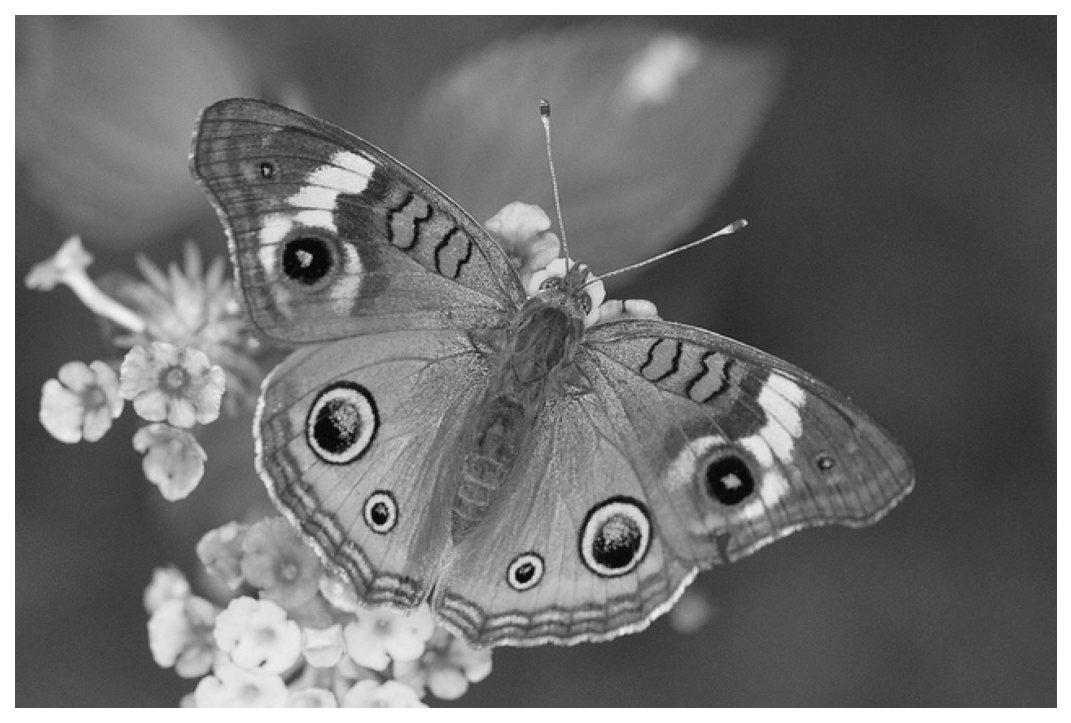

In [2]:
%matplotlib inline
# Ground truth image
xp=np
image = skimage.color.rgb2gray(skimage.io.imread('buckeye.jpg'))
imshow(image);

## Forward model (2D lens microsopy) $\mathbf{H} \in \mathbb{R}^{N \times N}$

$\mathbf{H}\mathbf{x}$: 2D convolution of the image $\mathbf{x}$ with $\mathbf{h_{2D}}$ (*point spread function* of the microscope).

In [3]:
# Lens' PSF
wsize= 15
filt = xp.asarray(scipy.signal.get_window('hamming', wsize)); filt/= filt.sum()
Lens = Stencil(kernel=[filt, filt], 
               center=(wsize//2 + 1,wsize//2 + 1), 
               arg_shape=image.shape, 
               mode='constant')
 
# Simulate data
sigma = 5 * 1e-2  # Noise level
data_lens_noiseless = Lens(image.ravel()) # Convolution with PSF
data_lens = data_lens_noiseless + sigma * np.random.randn(Lens.codim) # Add noise

# Data fidelity loss
ls_loss = 1 / 2 * SquaredL2Norm(dim=data_lens.size).argshift(-data_lens) * Lens

## Measured data $\mathbf{y} \in \mathbb{R}^{N}$

$$\mathbf{y} = \mathbf{H}\mathbf{x} + \mathbf{n},$$ where $\mathbf{n}$ is Gaussian white noise.


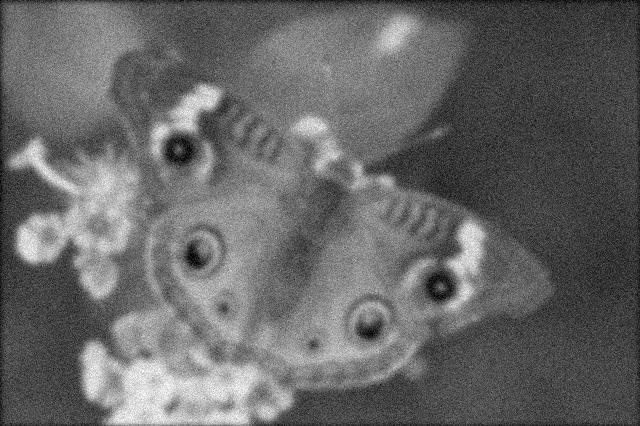
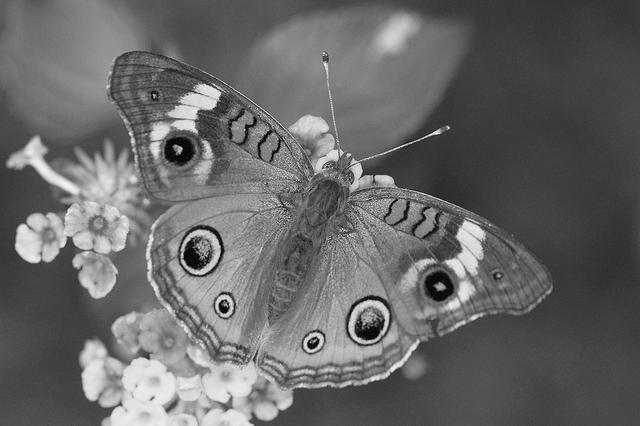

In [4]:

imshow_compare(data_lens.reshape(image.shape), image, start_mode="circle")

## Least-square reconstruction

$$\hat{\mathbf{x}}\in \arg\min_{\mathbf{x}\in\mathbb{R}^{N}} \frac12 \|\mathbf{H}\mathbf{x} - \mathbf{y}\|_2^2$$

**Gradient descent**

$$\mathbf{x}_{n+1} = \mathbf{x}_n-\gamma \nabla  J(\mathbf{x}_n; \mathbf{y})), \qquad n\geq 0$$

where $J(\mathbf{x}; \mathbf{y})=\frac12 \|\mathbf{H}\mathbf{x} - \mathbf{y}\|_2^2$ and $$\gamma < \frac{2}{\lambda_\max (\mathbf{H}^T \mathbf{H})}$$

<IPython.core.display.Javascript object>


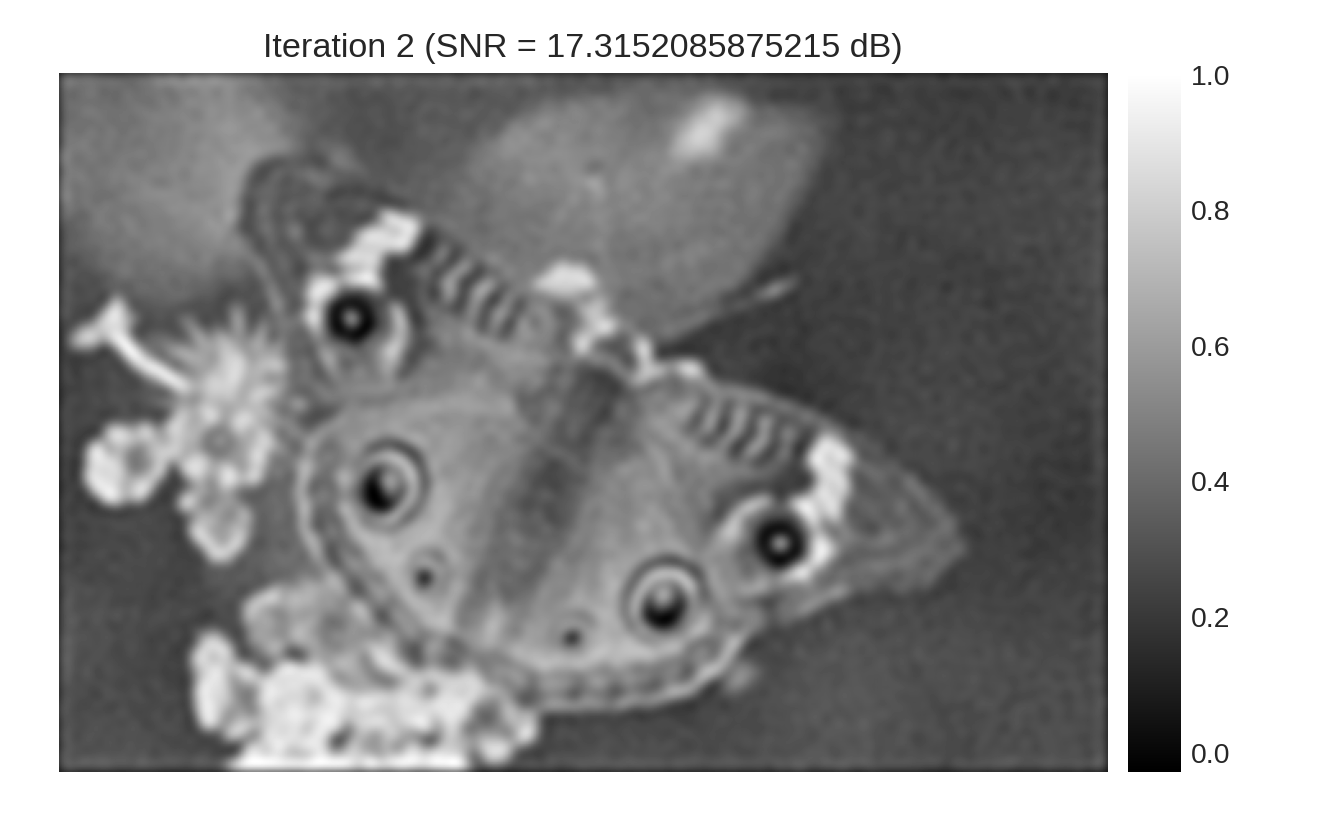

In [4]:
%matplotlib notebook
# Least square reconstruction

# Stopping criterion
stop_crit = RelError(eps=1e-4) | MaxIter(500)

# Initialize solver (gradient descent)
solver = PGD(f=ls_loss)

# Fit
x0 = np.zeros(image.size) # DownSampledLens.adjoint(data_lens)
solver.fit(mode=Mode.MANUAL, x0=x0, acceleration=False, stop_crit=stop_crit)
    
fig, ax, h = init_anim(x0, image)
anim = FuncAnimation(fig, lambda i: update_anim(i, solver, image, fig, ax, h), blit=False, interval=0)
plt.show()

INFO:/tmp/pycsou_xhb35n1_:[2023-06-01 09:54:06.108869] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO:/tmp/pycsou_xhb35n1_:[2023-06-01 09:54:06.902126] Iteration 100
	iteration: 100
	RelError[x]: 0.0006956878677069312
	N_iter: 101.0
INFO:/tmp/pycsou_xhb35n1_:[2023-06-01 09:54:07.579612] Iteration 200
	iteration: 200
	RelError[x]: 0.0005090827678909223
	N_iter: 201.0
INFO:/tmp/pycsou_xhb35n1_:[2023-06-01 09:54:08.283494] Iteration 300
	iteration: 300
	RelError[x]: 0.00043720661684173946
	N_iter: 301.0
INFO:/tmp/pycsou_xhb35n1_:[2023-06-01 09:54:08.970476] Iteration 400
	iteration: 400
	RelError[x]: 0.00039752355868590835
	N_iter: 401.0
INFO:/tmp/pycsou_xhb35n1_:[2023-06-01 09:54:09.804682] Iteration 500
	iteration: 500
	RelError[x]: 0.0003715233047903824
	N_iter: 501.0
INFO:/tmp/pycsou_xhb35n1_:[2023-06-01 09:54:09.805240] Stopping Criterion satisfied -> END


SNR = 10.975127322655593 dB


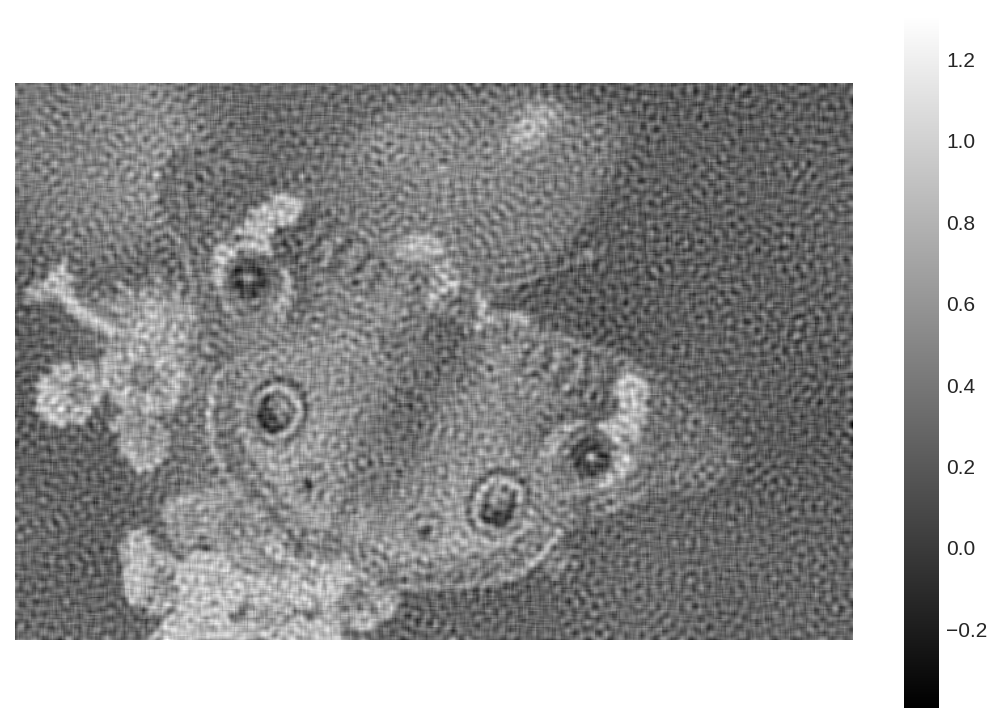

In [9]:
%matplotlib inline
# Stopping criterion
stop_crit = RelError(eps=1e-4) | MaxIter(500)

# Initialize solver (gradient descent)
solver = PGD(f=ls_loss, show_progress=False, verbosity=100)
# Fit
x0 = np.zeros(image.size)
solver.fit(x0=x0, acceleration=False, stop_crit=stop_crit)
im_ls = solver.solution().reshape(image.shape)
imshow(im_ls, colorbar=True)
print(f'SNR = {snr(im_ls, image)} dB')

**Gradient descent with too large step size** $$\gamma \geq \frac{2}{\lambda_\max (\mathbf{H}^T \mathbf{H})}$$

In [6]:
%matplotlib notebook
# Gradient descent with too large step size

# Stopping criterion
stop_crit = RelError(eps=1e-3) | MaxIter(100)

# Initialize solver (gradient descent)
solver = PGD(f=ls_loss)
tau = 3 / ls_loss.diff_lipschitz() # Set gradient descent step size too large

# Fit
x0 = np.zeros(image.size) # DownSampledLens.adjoint(data_lens)
solver.fit(mode=Mode.MANUAL, x0=x0, acceleration=False, tau=tau, stop_crit=stop_crit)
    
fig, ax, h = init_anim(x0, image)
anim = FuncAnimation(fig, lambda i: update_anim(i, solver, image, fig, ax, h), blit=False, interval=0)
plt.show()

## Imposing positivity: projected gradient descent
$$\hat{\mathbf{x}}\in \arg\min_{\mathbf{x}\in\mathbb{R}^{N}} \frac12 \|\mathbf{H}\mathbf{x} - \mathbf{y}\|_2^2 + i_{\mathbb{R}^+}(\mathbf{x})$$

where *indicator function* $i_{\mathbb{R}^+}(\mathbf{x}) = 0$ if $x_i \geq 0$ for all $i$, $i_{\mathbb{R}^+}(\mathbf{x}) = + \infty$ otherwise, and $\mathrm{prox}_{i_{\mathbb{R}^+}} = \mathrm{Proj}_{\mathbb{R}^+}$

Minimized using *forward-backward splitting*, which amounts to projected gradient descent:

$$\mathbf{x}_{n+1} = \mathrm{Proj}_{\mathbb{R}^+}(\mathbf{x}_n-\gamma \nabla J(\mathbf{x}_n; \mathbf{y})), \qquad n\geq 0$$

where $J(\mathbf{x}; \mathbf{y})=\frac12 \|\mathbf{H}\mathbf{x} - \mathbf{y}\|_2^2$

<IPython.core.display.Javascript object>


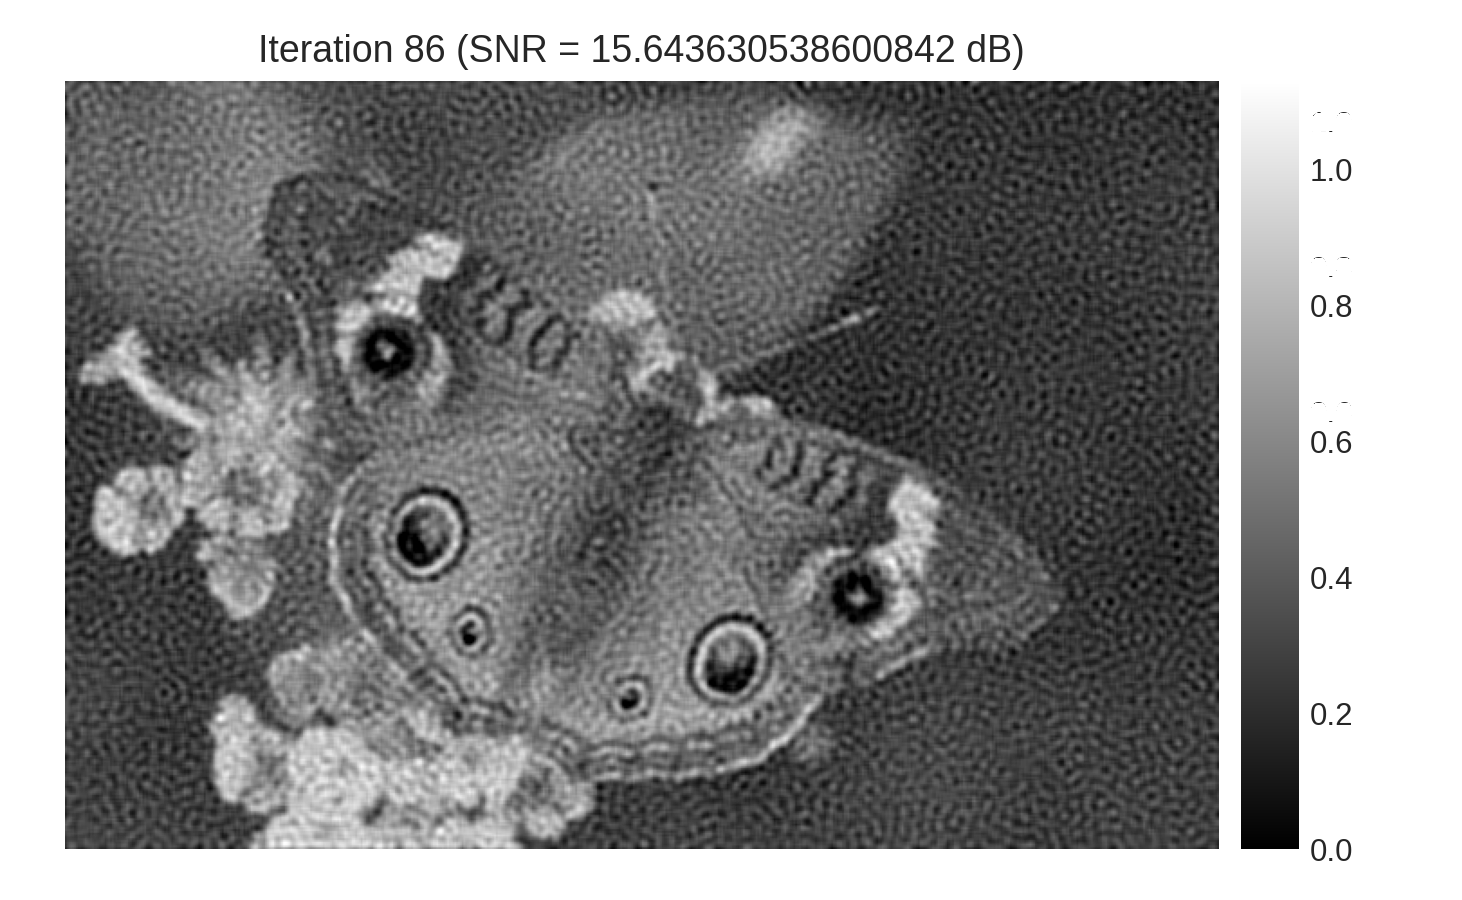

In [7]:
%matplotlib notebook
# Least squares with positivity constraint
g = PositiveOrthant(dim=image.size)

# Stopping criterion
default_stop_crit = (RelError(eps=1e-3)) | MaxIter(100)

# Initialize solver (proximal gradient descent)
solver = PGD(f=ls_loss, g=g)

# Fit
x0 = np.zeros(image.size) # DownSampledLens.adjoint(data_lens)
solver.fit(mode=Mode.MANUAL, x0=x0, acceleration=False, stop_crit=default_stop_crit)
    
fig, ax, h = init_anim(x0, image)
anim = FuncAnimation(fig, lambda i: update_anim(i, solver, image, fig, ax, h), blit=False, interval=0)
plt.show()

INFO:/tmp/pycsou_jmljgnay:[2023-05-31 23:06:19.812468] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO:/tmp/pycsou_jmljgnay:[2023-05-31 23:06:20.525497] Iteration 88
	iteration: 88
	RelError[x]: 0.0009996199011991541
	N_iter: 89.0
INFO:/tmp/pycsou_jmljgnay:[2023-05-31 23:06:20.525926] Stopping Criterion satisfied -> END


SNR = 15.654507772777656 dB


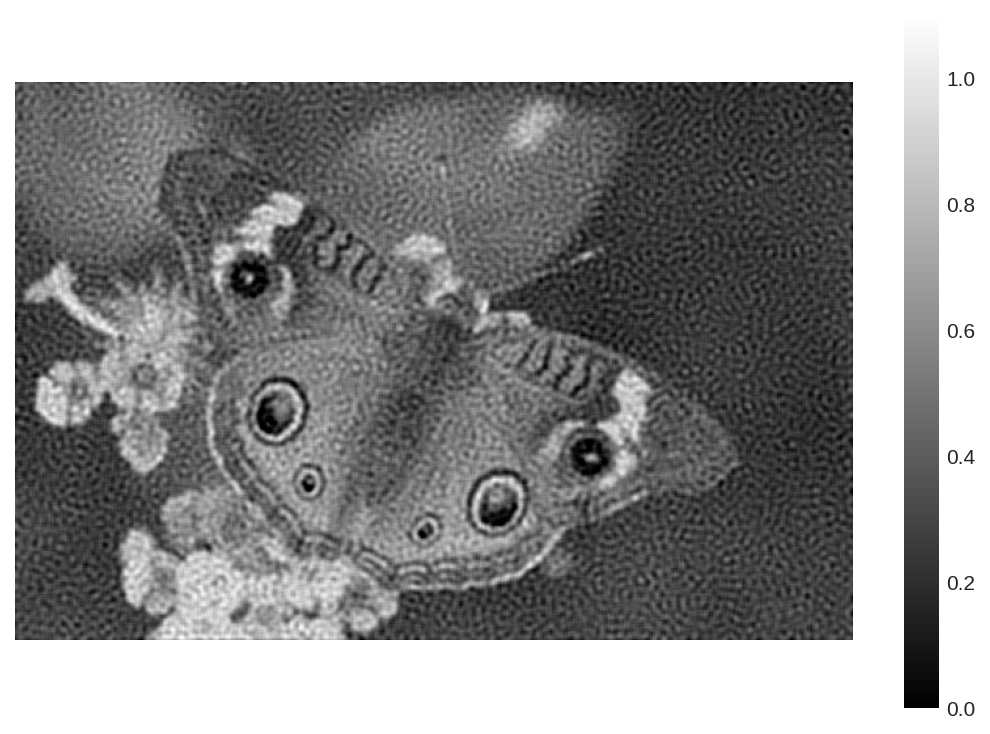

In [7]:
%matplotlib inline
# Least squares with positivity constraint
g = PositiveOrthant(dim=image.size)

# Stopping criterion
stop_crit = RelError(eps=1e-3) | MaxIter(100)

# Initialize solver (gradient descent)
solver = PGD(f=ls_loss, g=g, show_progress=False, verbosity=100)
# Fit
x0 = np.zeros(image.size)
solver.fit(x0=x0, acceleration=False, stop_crit=stop_crit)
im_ls_pos = solver.solution().reshape(image.shape)
imshow(im_ls_pos, colorbar=True)
print(f'SNR = {snr(im_ls_pos, image)} dB')

## Tikhonov regularization

$$\hat{\mathbf{x}}\in \arg\min_{\mathbf{x}\in\mathbb{R}^{N}} \frac12 \|\mathbf{H}\mathbf{x} - \mathbf{y}\|_2^2 + \lambda \|\nabla \mathbf{x}\|_2^2$$

### Gradient descent

<IPython.core.display.Javascript object>


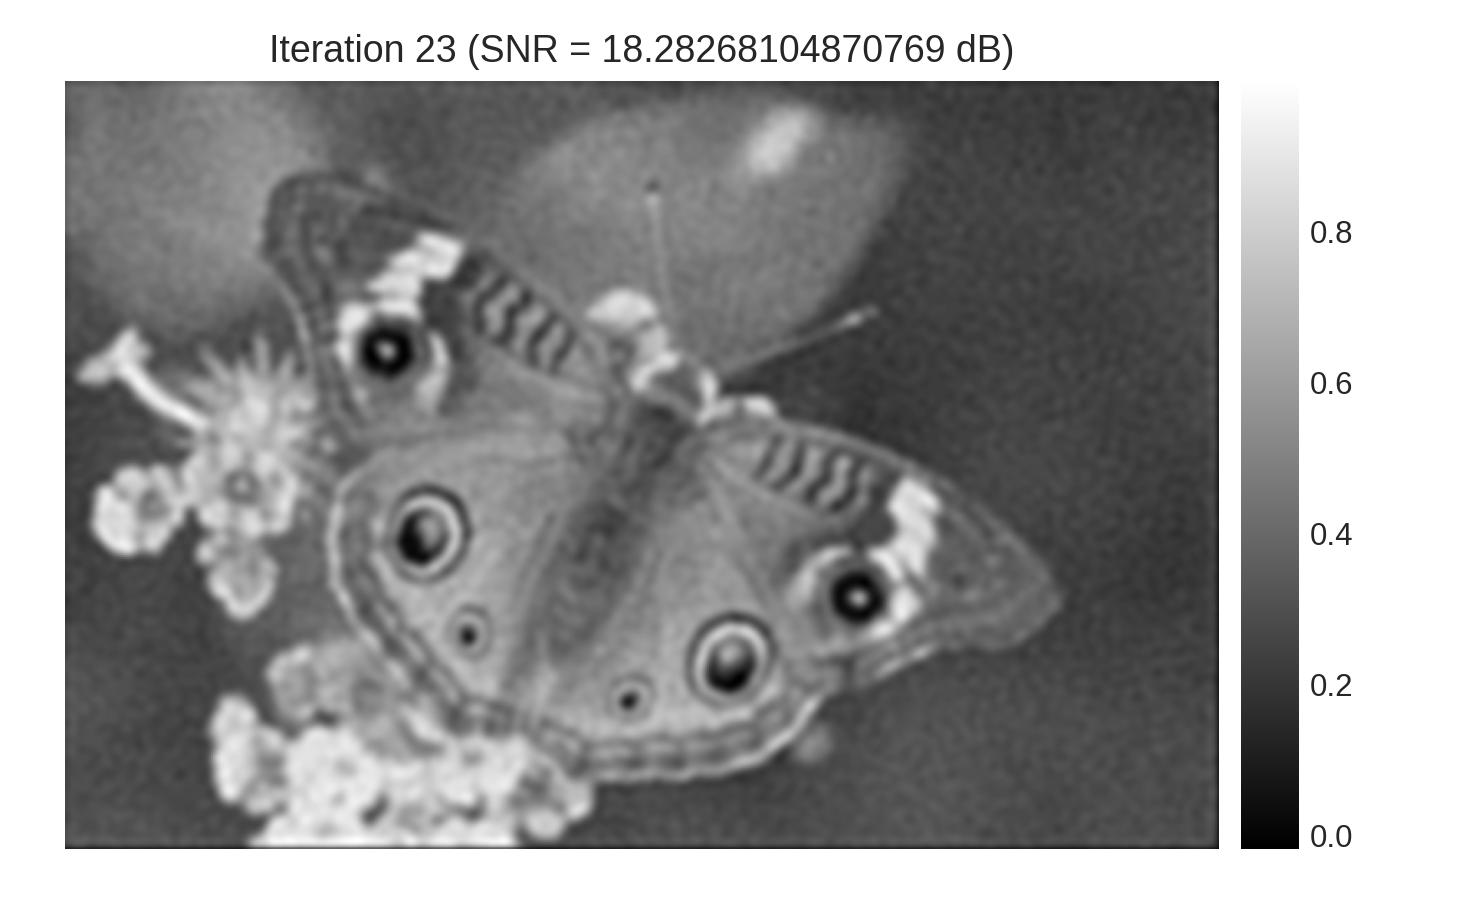

In [33]:
%matplotlib notebook
# Tikhonov regularization
lamb = 5*1e-2 # Regularization parameter
grad = Gradient(arg_shape = image.shape)
tik_reg = SquaredL2Norm(dim=grad.codim) * grad

# Stopping criterion
stop_crit = RelError(eps=1e-3) | MaxIter(100)

# Initialize solver (gradient descent)
solver = PGD(f=ls_loss + lamb * tik_reg)

# Fit
x0 = np.zeros(image.size) # DownSampledLens.adjoint(data_lens)

solver.fit(mode=Mode.MANUAL, x0=x0, acceleration=False, stop_crit=stop_crit)

fig, ax, h = init_anim(x0, image)
anim = FuncAnimation(fig, lambda i: update_anim(i, solver, image, fig, ax, h), blit=False, interval=0)
plt.show()

INFO:/tmp/pycsou_uaudkcjh:[2023-06-01 09:13:34.655257] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO:/tmp/pycsou_uaudkcjh:[2023-06-01 09:13:34.926904] Iteration 12
	iteration: 12
	RelError[x]: 0.000796038547360537
	N_iter: 13.0
INFO:/tmp/pycsou_uaudkcjh:[2023-06-01 09:13:34.927371] Stopping Criterion satisfied -> END


SNR = 17.749982458012703 dB


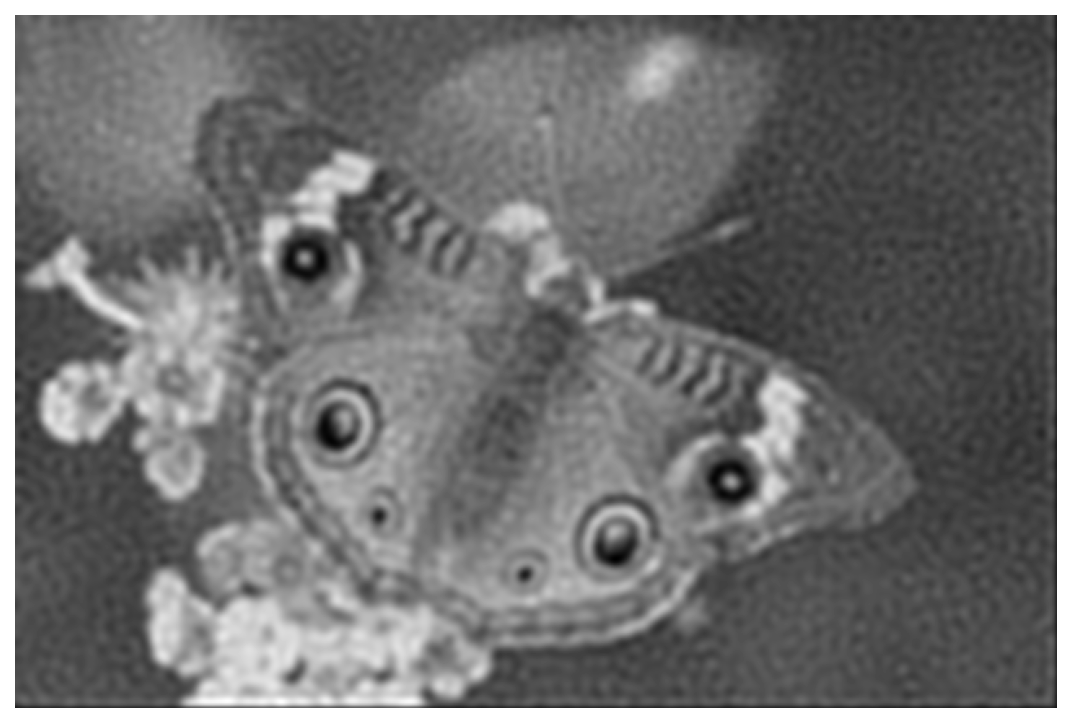

In [9]:
%matplotlib inline

lamb = 5*1e-2
grad = Gradient(arg_shape=image.shape)
tik_reg = SquaredL2Norm(dim=grad.codim) * grad
# Conjugate gradient descent
tik_cost = ls_loss + lamb * tik_reg
A, b, _ = tik_cost._quad_spec()
b = -b.grad(np.zeros(image.size))

# Stopping criterion
stop_crit = RelError(eps=1e-3) | MaxIter(100)

# Initialize solver (conjugate gradient descent)
solver = CG(A=A, show_progress=False, verbosity=100)

# Fit
x0 = np.zeros(image.size)
solver.fit(x0=x0, b=b, stop_crit=stop_crit)
im_tik = solver.solution().reshape(image.shape)
imshow(im_tik)
print(f'SNR = {snr(im_tik, image)} dB')

### Conjugate gradient: more efficient

<IPython.core.display.Javascript object>


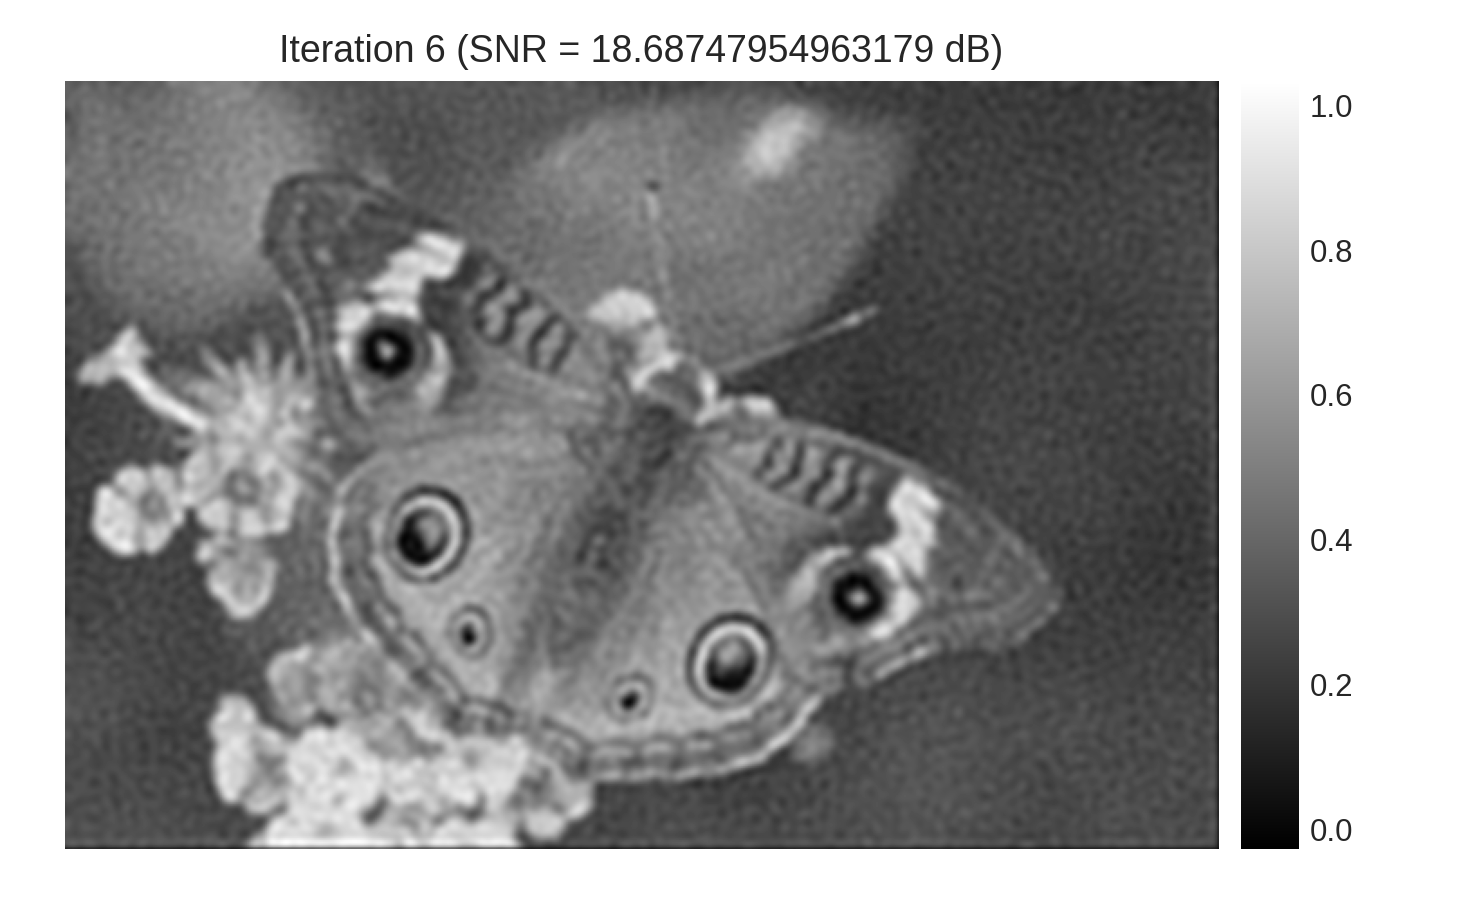

In [9]:
%matplotlib notebook
lamb = 5e-2
grad = Gradient(arg_shape=image.shape)
tik_reg = SquaredL2Norm(dim=grad.codim) * grad
# Conjugate gradient descent
tik_cost = ls_loss + lamb * tik_reg
A, b, _ = tik_cost._quad_spec()
b = -b.grad(np.zeros(image.size))

# Stopping criterion
stop_crit = RelError(eps=1e-3) | MaxIter(100)

# Initialize solver (conjugate gradient descent)
solver = CG(A=A)

# Fit
x0 = np.zeros(image.size) # DownSampledLens.adjoint(data_lens)

solver.fit(mode=Mode.MANUAL, x0=x0, b=b, stop_crit=stop_crit)
    
fig, ax, h = init_anim(x0, image)
anim = FuncAnimation(fig, lambda i: update_anim(i, solver, image, fig, ax, h), blit=False, interval=0)
plt.show()

In [ ]:
im_tik = solver.solution().reshape(image.shape)

## Effect of regularization parameter $\lambda$

In [4]:
# Effect of regularization parameter (Tikhonov regularization)
lamb_list = 5*10 ** np.linspace(-4, 0, num=5, endpoint=True)
grad = Gradient(arg_shape=image.shape)
tik_reg = SquaredL2Norm(dim=grad.codim) * grad
im_tik_list = np.zeros((*image.shape, len(lamb_list)))

# Stopping criterion
stop_crit = RelError(eps=1e-3) | MaxIter(100)

for i in range(len(lamb_list)):
    tik_cost = ls_loss + lamb_list[i] * tik_reg
    A, b, _ = tik_cost._quad_spec()
    b = -b.grad(np.zeros(image.size))

    # Initialize solver (proximal gradient descent)
    solver = CG(A=A, show_progress=False, verbosity=100)

    # Fit
    x0 = np.zeros(image.size) # DownSampledLens.adjoint(data_lens)
    solver.fit(x0=x0, b=b, stop_crit=stop_crit)
    im_tik_list[:, :, i] = solver.solution().reshape(image.shape)

INFO:/tmp/pycsou_qpe85k6a:[2023-06-01 13:49:02.521379] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO:/tmp/pycsou_qpe85k6a:[2023-06-01 13:49:04.053597] Iteration 73
	iteration: 73
	RelError[x]: 0.0009498407540397367
	N_iter: 74.0
INFO:/tmp/pycsou_qpe85k6a:[2023-06-01 13:49:04.054170] Stopping Criterion satisfied -> END
INFO:/tmp/pycsou_slg8m74e:[2023-06-01 13:49:04.190610] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO:/tmp/pycsou_slg8m74e:[2023-06-01 13:49:04.760006] Iteration 28
	iteration: 28
	RelError[x]: 0.0008566385731771118
	N_iter: 29.0
INFO:/tmp/pycsou_slg8m74e:[2023-06-01 13:49:04.760517] Stopping Criterion satisfied -> END
INFO:/tmp/pycsou_15tf3e2r:[2023-06-01 13:49:04.893716] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO:/tmp/pycsou_15tf3e2r:[2023-06-01 13:49:05.207942] Iteration 12
	iteration: 12
	RelError[x]: 0.0007893123997398242
	N_iter: 13.0
INFO:/tmp/pycsou_15tf3e2r:[2023-06-01 13:49:05.208501] Stopping Criterion satisfied

<IPython.core.display.Javascript object>


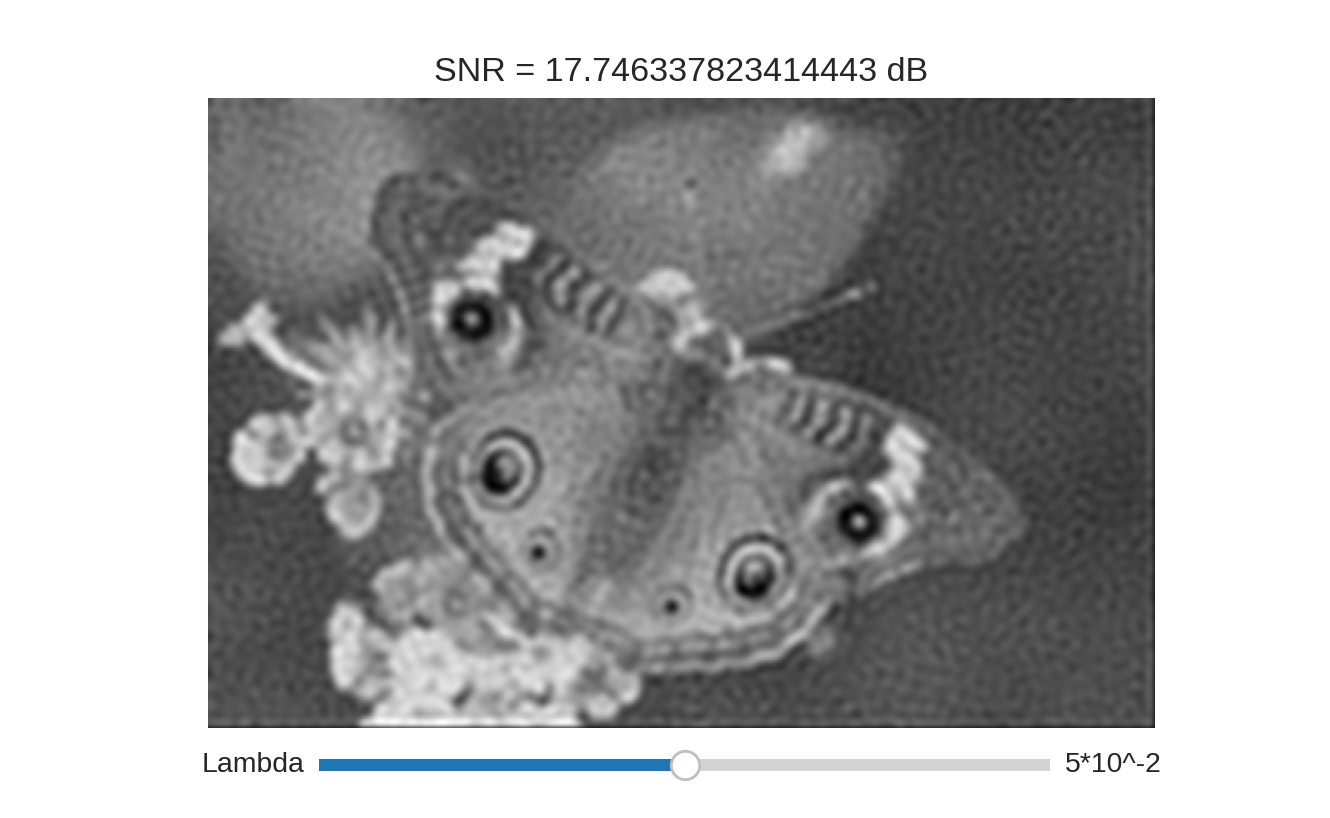

In [5]:
%matplotlib notebook
# Slider plot
idx0 = 2
plt.figure(figsize=(6.5,4))
l = plt.imshow(im_tik_list[:, :, int(idx0)], cmap="gray")
ax = plt.gca()
ax.set_title(f'SNR = {snr(im_tik_list[:, :, int(idx0)], image)} dB')
plt.axis("off")

axidx = plt.axes([0.24, 0.05, 0.55, 0.03])
valmin, valmax = -4, 0
slidx = Slider(axidx, 'Lambda', valmin=valmin, valmax=valmax, valinit=-2, valfmt='5*10^%d', valstep=1)

def update(val):
    idx = slidx.val
    l.set_data(im_tik_list[:, :, int(idx-valmin)])
    ax.set_title(f'SNR = {snr(im_tik_list[:, :, int(idx-valmin)], image)} dB')
    fig.canvas.draw_idle()
    
slidx.on_changed(update)
plt.show()

## TV regularization

$$\hat{\mathbf{x}}\in \arg\min_{\mathbf{x}\in\mathbb{R}^{N}} \frac12 \|\mathbf{H}\mathbf{x} - \mathbf{y}\|_2^2 + \lambda \mathrm{TV}(\mathbf{x})$$

<IPython.core.display.Javascript object>


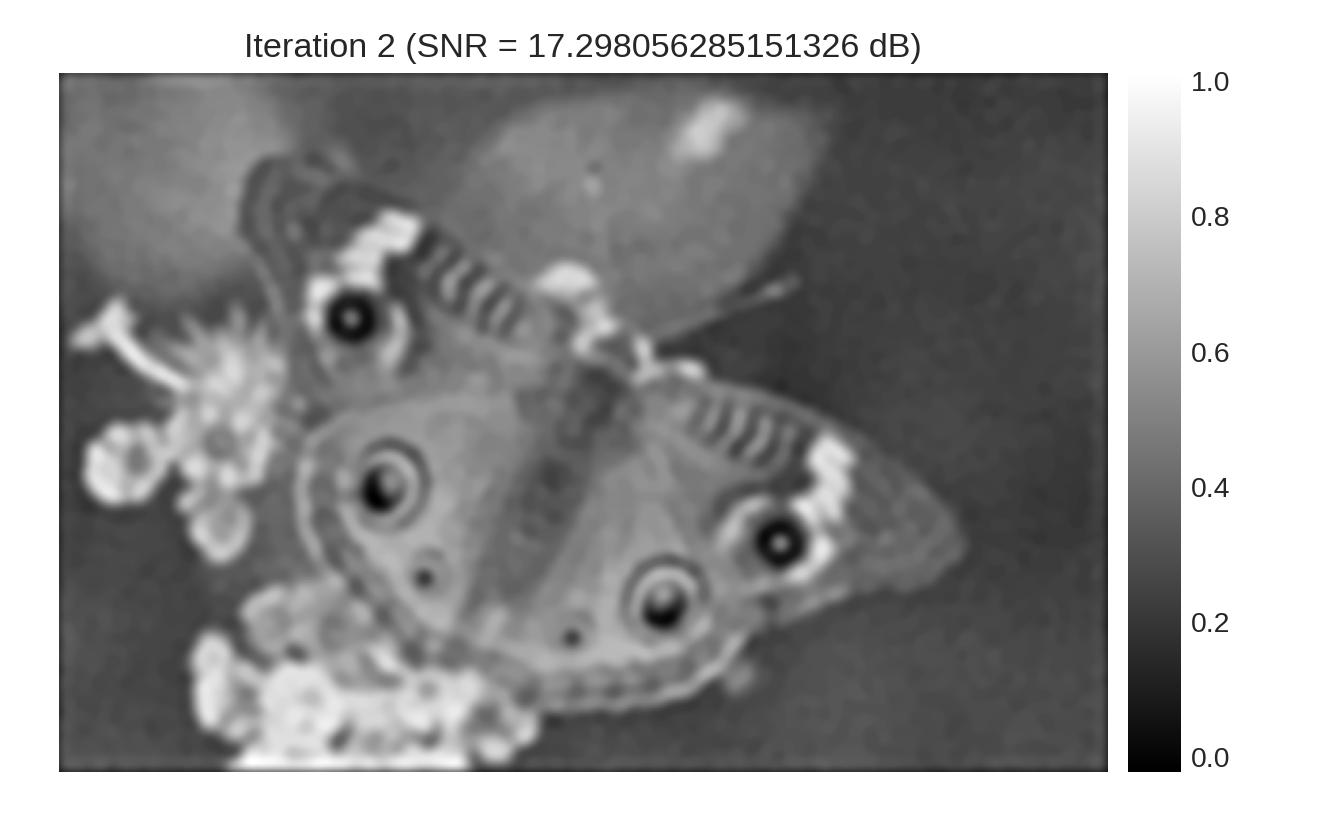

In [6]:
%matplotlib notebook
# TV regularization
lamb = 3*1e-3 # Regularization parameter
TV_reg = lamb * TVFunc(arg_shape=image.shape)

# Stopping criterion
stop_crit = RelError(eps=1e-3) | MaxIter(100)

# Initialize solver (gradient descent)
solver = PGD(f=ls_loss, g=TV_reg)

# Fit
x0 = np.zeros(image.size) # DownSampledLens.adjoint(data_lens)
solver.fit(mode=Mode.MANUAL, x0=x0, acceleration=False, stop_crit=stop_crit)

fig, ax, h = init_anim(x0, image)
anim = FuncAnimation(fig, lambda i: update_anim(i, solver, image, fig, ax, h), blit=True, interval=0)
plt.show()

In [11]:
%matplotlib inline
# TV regularization
lamb = 3*1e-3 # Regularization parameter
TV_reg = lamb * TVFunc(arg_shape=image.shape)

# Stopping criterion
stop_crit = RelError(eps=1e-3) | MaxIter(100)

# Initialize solver (gradient descent)
solver = PGD(f=ls_loss, g=TV_reg, show_progress=False, verbosity=100)

# Fit
x0 = np.zeros(image.size) # DownSampledLens.adjoint(data_lens)
solver.fit(x0=x0, acceleration=False, stop_crit=stop_crit)
im_TV = solver.solution().reshape(image.shape)
print(f'SNR = {snr(im_TV, image)} dB')

INFO:/tmp/pycsou_3foy4otl:[2023-06-01 09:14:29.167424] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO:/tmp/pycsou_nj5k7nji:[2023-06-01 09:14:29.207244] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO:/tmp/pycsou_nj5k7nji:[2023-06-01 09:14:29.459064] Iteration 11
	iteration: 11
	N_iter: 12.0
	RelError[x]: 9.198223587850466e-05
INFO:/tmp/pycsou_nj5k7nji:[2023-06-01 09:14:29.459576] Stopping Criterion satisfied -> END
INFO:/tmp/pycsou_c55jg4lb:[2023-06-01 09:14:29.506278] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO:/tmp/pycsou_c55jg4lb:[2023-06-01 09:14:29.737174] Iteration 12
	iteration: 12
	N_iter: 13.0
	RelError[x]: 8.412857799131883e-05
INFO:/tmp/pycsou_c55jg4lb:[2023-06-01 09:14:29.737725] Stopping Criterion satisfied -> END
INFO:/tmp/pycsou_9r3s1mgs:[2023-06-01 09:14:29.788577] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO:/tmp/pycsou_9r3s1mgs:[2023-06-01 09:14:30.128831] Iteration 12
	iteration: 12
	N_iter: 13.0
	RelErr

INFO:/tmp/pycsou_rq43r05p:[2023-06-01 09:14:37.456145] Iteration 14
	iteration: 14
	N_iter: 15.0
	RelError[x]: 8.470788601026615e-05
INFO:/tmp/pycsou_rq43r05p:[2023-06-01 09:14:37.456771] Stopping Criterion satisfied -> END
INFO:/tmp/pycsou__9y6pq3o:[2023-06-01 09:14:37.485598] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO:/tmp/pycsou__9y6pq3o:[2023-06-01 09:14:37.764694] Iteration 14
	iteration: 14
	N_iter: 15.0
	RelError[x]: 8.549615555067524e-05
INFO:/tmp/pycsou__9y6pq3o:[2023-06-01 09:14:37.765363] Stopping Criterion satisfied -> END
INFO:/tmp/pycsou_3foy4otl:[2023-06-01 09:14:37.774722] Iteration 26
	iteration: 26
	RelError[x]: 0.0009853790444259204
	N_iter: 27.0
INFO:/tmp/pycsou_3foy4otl:[2023-06-01 09:14:37.775165] Stopping Criterion satisfied -> END


SNR = 18.25268404307171 dB



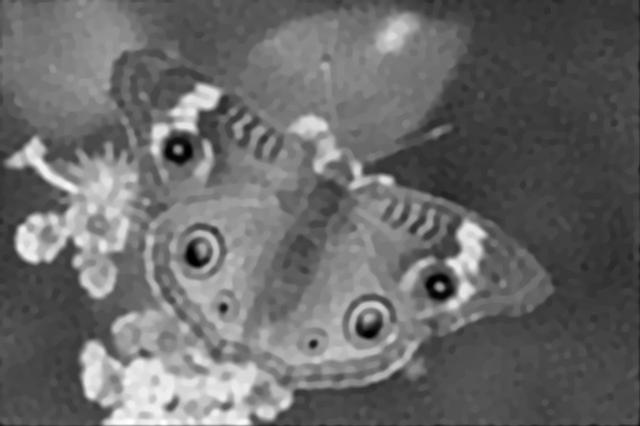
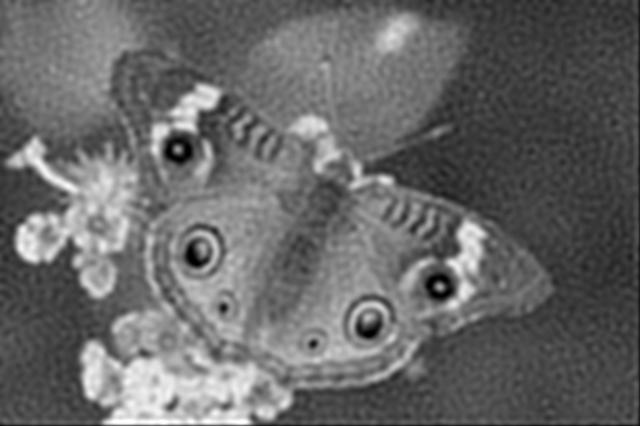

In [12]:
%matplotlib inline
im_TV = solver.solution().reshape(image.shape)
imshow_compare(im_TV, im_tik, start_mode="circle")

## Plug-and-Play Reconstruction

Alternatively, one can consider a reconstruction scheme involving an implicit *plug-and-play prior*, defined as a denoiser:  

$$\mathbf{x}_{n+1} = \text{denoiser}_\rho(\mathbf{x}_n-\tau \nabla J(\mathbf{x}_n; \mathbf{y})), \qquad n\geq 0$$

where 

$$J(\mathbf{x}; \mathbf{y})=\frac12 \|\mathbf{H}\mathbf{x} - \mathbf{y}\|_2^2$$ 

In [13]:
class BM3D(ProxFunc):
    def __init__(self, arg_shape):
        dim = np.prod(arg_shape)
        super().__init__(shape=(1, dim))
        self._arg_shape = arg_shape
        
    def apply(self,arr):
        return NotImplemented
        
    def prox(self, arr, tau):
        return bm3d(arr.reshape(self._arg_shape), 3*1e-2*np.sqrt(tau)).ravel()
            

bm3d_func = BM3D(image.shape)

In [14]:
solver = PGD(f=ls_loss, g=bm3d_func, show_progress=False, verbosity=100)
solver.fit(x0=np.zeros(image.size), acceleration=False, stop_crit=MaxIter(25))
im_bm3d = solver.solution().reshape(image.shape)

INFO:/tmp/pycsou_s9k2q72_:[2023-06-01 09:15:23.780223] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pycsou_s9k2q72_:[2023-06-01 09:16:44.674659] Iteration 25
	iteration: 25
	N_iter: 26.0
INFO:/tmp/pycsou_s9k2q72_:[2023-06-01 09:16:44.675351] Stopping Criterion satisfied -> END


SNR = 18.487576872527086 dB



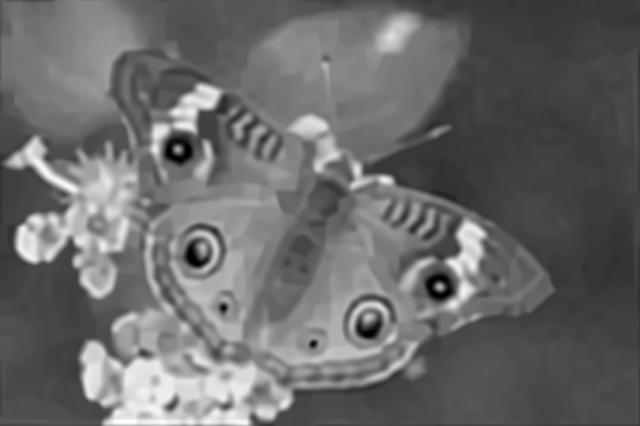
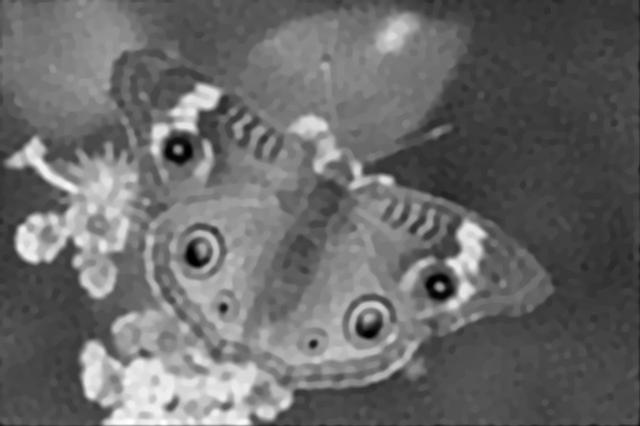

In [15]:
%matplotlib inline
print(f'SNR = {snr(im_bm3d, image)} dB')
imshow_compare(im_bm3d, im_TV, start_mode="circle")

# Demo: Computed Tomography (CT) Reconstruction

## Measurements: sinogram with faulty detectors, uniform filtering,  tapering, and noise

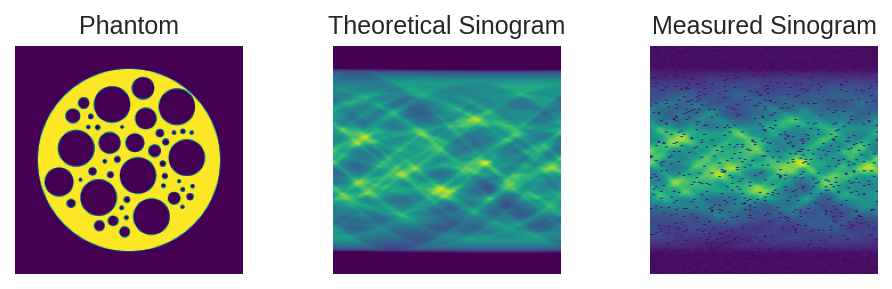

In [60]:
# Generate phantom
np.random.seed(0)
p1 = xdesign.Foam(size_range=[0.1, 0.01], gap=0.025, porosity=0.5)
phantom = xdesign.discrete_phantom(p1, 160) * 10
phantom = np.abs(np.pad(phantom, 20))

# Generate sinogram 
rng = np.random.default_rng(0)
psnr = 20 # 10 * log(s/n) = psnr => n = s * 10^(-psnr/10)
angles, wsize = 90, 5
sino0 = skt.radon(phantom, theta=np.linspace(0, 180, angles), circle=True)
sino = sp.ndimage.uniform_filter(sino0, [wsize, 0], mode='constant')
mask = rng.binomial(1, 0.95, sino.shape)
sino *= mask
sino *= scipy.signal.get_window('hamming', sino.shape[0])[:, None]
sigma = np.abs(sino).max() * (10**(-psnr/10))
sino += rng.normal(scale=sigma, size=sino.shape)

plt.figure(figsize=(6.5,2))
_ = plt.subplot(1,3,1)
_ = plt.imshow(phantom)
_ = plt.title("Phantom")
_ = plt.axis('off')

_ = plt.subplot(1,3,2)
_ = plt.imshow(sino0, aspect=0.45)
_ = plt.title("Theoretical Sinogram")
_ = plt.axis('off')

_ = plt.subplot(1,3,3)
_ = plt.imshow(sino, aspect=0.45)
_ = plt.title("Measured Sinogram")
_ = plt.axis('off')
plt.tight_layout()
plt.show()

## Reconstruction with simple filtered backprojection

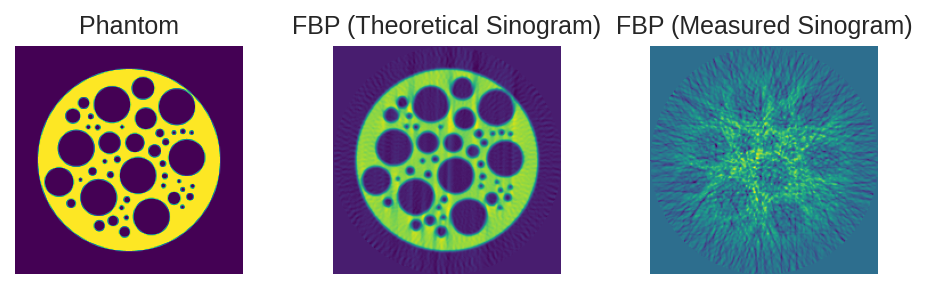

In [61]:
plt.figure(figsize=(6.5,2))
_ = plt.subplot(1,3,1)
_ = plt.imshow(phantom)
_ = plt.title('Phantom')
_ = plt.axis('off')
_ = plt.subplot(1,3,2)
_ = plt.imshow(skt.iradon(radon_image=sino0, circle=True, filter_name="hamming"))
_ = plt.title('FBP (Theoretical Sinogram)')
_ = plt.axis('off')
_ = plt.subplot(1,3,3)
_ = plt.imshow(skt.iradon(radon_image=sino, circle=True, filter_name="hamming"))
_ = plt.title('FBP (Measured Sinogram)')
_ = plt.axis('off')
plt.tight_layout()
plt.show()

## More accurate forward model
$\mathbf{H} \in \mathbb{R}^{M \times N}$ where $M = n_\theta \times n_d$:
* $n_\theta$: number of angles
* $n_d$: number of detectors

In [62]:
# Radon Operator
Radon = from_source(cls=LinOp,
                    shape=(sino.size, phantom.size),
                    apply=lambda self, arr: skt.radon(arr.reshape(phantom.shape), 
                                                      theta=np.linspace(0, 180, angles), 
                                                      circle=True).ravel(),
                    adjoint=lambda self, arr: skt.iradon(arr.reshape(sino.shape), 
                                                         filter_name=None, 
                                                         circle=True).ravel(),
                    vectorize=["apply", "adjoint"], vmethod="scan", enforce_precision=["apply", "adjoint"])

# 1D Filtering
boxcar = np.asarray(scipy.signal.get_window("boxcar", wsize)); boxcar /= wsize
BoxCar1D = Stencil(kernel=[boxcar, np.array([1.0])], center=(wsize // 2, 0), arg_shape=sino.shape,)

# Partial Masking
Mask = DiagonalOp(mask.ravel())

# Tapering
taper = np.outer(scipy.signal.get_window("hamming", sino.shape[0]), np.ones(sino.shape[1]))
Taper = DiagonalOp(taper.ravel())

# Compose operators
Phi = Taper * Mask * BoxCar1D * Radon

predicted_sino = Phi(phantom.ravel()).reshape(sino.shape)

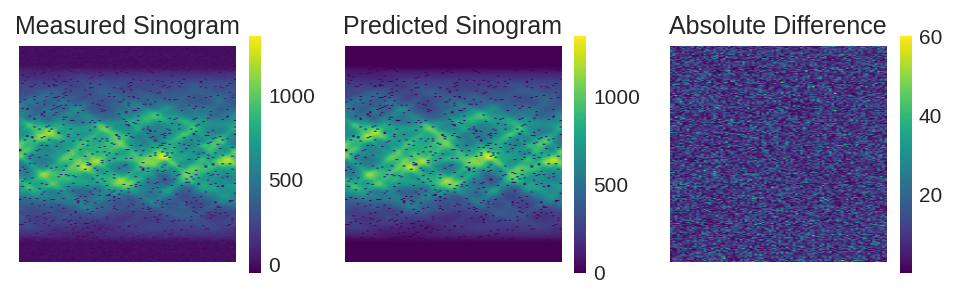

In [63]:
plt.figure(figsize=(6.5,2))
_ = plt.subplot(1,3,1)
_ = plt.imshow(sino, aspect=0.45)
_ = plt.colorbar()
_ = plt.title("Measured Sinogram")
_ = plt.axis('off')

_ = plt.subplot(1,3,2)
_ = plt.imshow(predicted_sino, aspect=0.45)
_ = plt.colorbar()
_ = plt.title("Predicted Sinogram")
_ = plt.axis('off')

_ = plt.subplot(1,3,3)
_ = plt.imshow(np.abs(sino-predicted_sino), aspect=0.45)
_ = plt.colorbar()
_ = plt.title("Absolute Difference")
_ = plt.axis('off')
plt.tight_layout()
plt.show()

## Pseudo-Inverse Solution

Least squares with dampening parameter $\lambda$

$$\hat{\mathbf{x}}\in \arg\min_{\mathbf{x}\in\mathbb{R}^{N}} \frac12 \|\mathbf{H}\mathbf{x} - \mathbf{y}\|_2^2 + \frac{\lambda}{2} \|\mathbf{x}\|_2^2 = (\mathbf{H}^T \mathbf{H} + \lambda \mathbf{I} )^{-1} \mathbf{H}^T \mathbf{y}$$

In [64]:
default_stop_crit = RelError(eps=1e-3, var="x", f=None, norm=2, satisfy_all=True) | MaxIter(500)
pinv_solution = Phi.pinv(sino.ravel(), damp=4,  
                         kwargs_init=dict(show_progress=False, verbosity=50),
                         kwargs_fit=dict(stop_crit=default_stop_crit))

INFO:/tmp/pycsou_ntedu7ge:[2023-06-01 00:14:08.112675] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO:/tmp/pycsou_ntedu7ge:[2023-06-01 00:14:09.205509] Iteration 18
	iteration: 18
	RelError[x]: 0.0008930069037398753
	N_iter: 19.0
INFO:/tmp/pycsou_ntedu7ge:[2023-06-01 00:14:09.206134] Stopping Criterion satisfied -> END


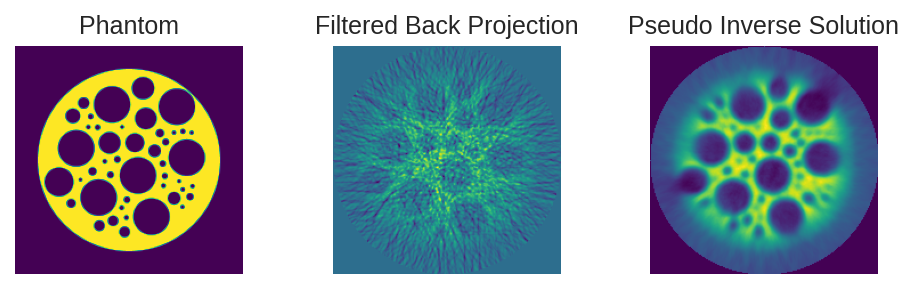

In [65]:
plt.figure(figsize=(6.5,2))
_ = plt.subplot(1,3,1)
_ = plt.imshow(phantom)
_ = plt.title('Phantom')
_ = plt.axis('off')
_ = plt.subplot(1,3,2)
_ = plt.imshow(skt.iradon(radon_image=sino, circle=True, filter_name="hamming"))
_ = plt.title('Filtered Back Projection')
_ = plt.axis('off')
_ = plt.subplot(1,3,3)
_ = plt.imshow(pinv_solution.reshape(phantom.shape))
_ = plt.title('Pseudo Inverse Solution')
_ = plt.axis('off')
plt.tight_layout()
plt.show()

## TV Regularization with Positivity Constraint Reconstruction

$$\hat{\mathbf{x}}\in \arg\min_{\mathbf{x}\in\mathbb{R}^{N}} \frac12 \|\mathbf{H}\mathbf{x} - \mathbf{y}\|_2^2 + \lambda \| \nabla \mathbf{x}\|_1 + \mu \|\mathbf{x}\|_1 + i_{\mathbb{R}^+}(\mathbf{x})$$

In [77]:
# TV prior
grad = Gradient(arg_shape=phantom.shape, accuracy=4, mode='constant', diff_method='fd')
lambda_= 0.025
huber_norm = L21Norm(arg_shape=(2, *phantom.shape)).moreau_envelope(0.01)
tv_prior = lambda_ * huber_norm * grad

# Positivity + L1 norm 
posL1 = 10 * PositiveL1Norm(phantom.size)

# Loss
loss = 1/2 * SquaredL2Norm(dim=sino.size).asloss(sino.ravel()) * Phi

# Posterior
posterior = loss + tv_prior
beta = posterior.diff_lipschitz(tight=True, tol=0.1)

In [78]:
from pycsou.opt.solver import PGD

solver = PGD(f=loss_total, g=g, show_progress=False, verbosity=250)
solver.fit(x0=0*pinv_solution.ravel(), tau=1/beta, acceleration=True, stop_crit=default_stop_crit)
recon_tv = solver.solution().squeeze()

INFO:/tmp/pycsou_9ab7gve3:[2023-06-01 00:21:06.923877] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO:/tmp/pycsou_9ab7gve3:[2023-06-01 00:21:23.654276] Iteration 250
	iteration: 250
	RelError[x]: 0.0019854331651156004
	N_iter: 251.0
INFO:/tmp/pycsou_9ab7gve3:[2023-06-01 00:21:40.355077] Iteration 500
	iteration: 500
	RelError[x]: 0.0016730029850149325
	N_iter: 501.0
INFO:/tmp/pycsou_9ab7gve3:[2023-06-01 00:21:40.355702] Stopping Criterion satisfied -> END


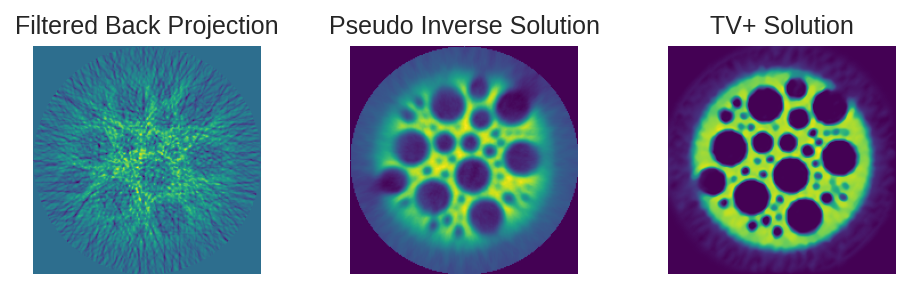

In [79]:
plt.figure(figsize=(6.5,2))
_ = plt.subplot(1,3,1)
_ = plt.imshow(skt.iradon(radon_image=sino, circle=True, filter_name="hamming"))
_ = plt.title('Filtered Back Projection')
_ = plt.axis('off')
_ = plt.subplot(1,3,2)
_ = plt.imshow(pinv_solution.reshape(phantom.shape))
_ = plt.title('Pseudo Inverse Solution')
_ = plt.axis('off')
_ = plt.subplot(1,3,3)
_ = plt.imshow(recon_tv.reshape(phantom.shape))
_ = plt.title('TV+ Solution')
_ = plt.axis('off')
plt.tight_layout()
plt.show()